# Social media analysis

Performing basic analysis on social media data over time. The data has been downloaded via a script set to run daily on Google Cloud Platform.

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
import re
import math
import os

import matplotlib.pyplot as plt
import matplotlib as matplot
from matplotlib import cm
import seaborn as sns
import itertools
import pickle

from tqdm import tqdm

%matplotlib inline
# Matplotlib params
plt.rcParams['figure.figsize'] = (16,9)
plt.style.use('ggplot')

# Pandas display options
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

# show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
data_files = os.listdir('data')

In [12]:
data = defaultdict()
for data_file in data_files:
    key = re.sub('.pkl|ig - ','',data_file)
    data[key] = pickle.load( open("data/"+data_file,"rb"))

# Data prep

### append_index

In [13]:
def append_index(d, i, axis=0):
    """ Append index to outer level of dataframe.
    f: dataframe
    i: string to be given as outer index
    
    axis: 0 for rows, 1 for columns"""
    f = d.copy()
    
    if axis == 0:
        ind = [np.array([i]*f.shape[0]),f.index]
        return f.set_index(ind)
    
    elif axis == 1:
        cols = np.vstack((np.array([i]*f.shape[1]),
                  np.array(f.columns.tolist()).T)) 
        f.columns = cols.tolist()
        return f

## General

In [14]:
data['2020-06-08'] = data['2020-06-08']['2020-06-08']

In [15]:
out = defaultdict()

## Posts

In [16]:
posts = pd.DataFrame()
for key in reversed(list(data.keys())):
    temp = data[key]['Posts']
    temp['date captured'] = key 
    posts = pd.concat([posts,temp],axis=0,sort=False)

In [17]:
from datetime import datetime

In [18]:
posts['timestamp'] = posts['timestamp'].apply(lambda x: x.date)
posts['date captured'] = posts['date captured'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

In [19]:
posts = posts.sort_values(by = 'date captured').drop_duplicates(subset = ['permalink'],keep='last').sort_values(by='timestamp')

In [20]:
out['Posts'] = posts

In [21]:
posts.sample()

,caption,media_type,media_url,permalink,timestamp,like_count,comments_count,username,comments,thumbnail_url,engagement,impressions,reach,saved,date captured,video_views
id,,,,,,,,,,,,,,,,
17885204251555145,Με αφορμή τον σημερινό εορτασμό της Παγκόσμιας...,IMAGE,https://scontent.cdninstagram.com/v/t51.29350-...,https://www.instagram.com/p/B_R_bY2l4Tq/,2020-04-22,225,2,letsdoitgreece,{'data': [{'timestamp': '2020-04-22T18:29:51+0...,NaN,229,2123,1912,2,2020-06-08,NaN


## Stories

In [54]:
stories = pd.DataFrame()
for key in reversed(list(data.keys())):
    temp = data[key]['Stories'].drop([p for p in stories.index.tolist() if p in data[key]['Stories'].index.tolist()])
    stories = pd.concat([stories,temp],axis=0,sort=False)

In [56]:
stories = stories.sort_values(by =[ 'datetime','impressions'],ascending = [True,False])

In [57]:
s_total = stories[['exits','impressions','reach','replies','taps_forward','taps_back','datetime']].\
                        set_index('datetime').astype('int64').groupby(axis=0,level=0).sum()

In [58]:
s_mean = stories[['exits','impressions','reach','replies','taps_forward','taps_back','datetime']].\
                        set_index('datetime').astype('int64').groupby(axis=0,level=0).mean()

s_m_norm = s_mean.T.div(s_mean['reach']).T

In [59]:
s_count = stories.groupby('datetime').count()['reach'].to_frame()

In [60]:
from sklearn.preprocessing import MinMaxScaler

In [61]:
sc = MinMaxScaler(feature_range = (0,s_mean['reach'].max()*0.8))

In [62]:
to_fit = s_count['reach']

In [63]:
normalized_cnt = sc.fit_transform(np.append(to_fit,0).reshape(-1,1))

In [64]:
s_count['normalized count'] = normalized_cnt[:-1]

In [65]:
stories_out = pd.concat([append_index(s_total,'Sum',axis=1),
                         append_index(s_mean,'Mean',axis=1),
                       append_index(s_count['reach'].to_frame(),'Count',axis=1)],
                      axis=1,sort=False)

In [66]:
stories_out.loc['2020-06-18'] = np.nan
stories_out.dropna(how='all',inplace=True)

In [67]:
out['Stories'] = stories_out

In [68]:
stories_out.sample()

Sum                                                     Mean  \
            exits impressions   reach replies taps_forward taps_back exits   
datetime                                                                     
2020-06-08  159.0      3266.0  2914.0     5.0       2197.0     109.0  31.8   

                                                             Count  
           impressions  reach replies taps_forward taps_back reach  
datetime                                                            
2020-06-08       653.2  582.8     1.0        439.4      21.8   5.0

# Followers data

In [36]:
account = pd.Series(dtype='int64',name = 'followers')
for key in data.keys():
    try:
        account[key] = data[key]['basic info'].loc['followers_count','business_discovery']
    except:
        continue

In [37]:
out['Account'] = account.to_frame()

In [39]:
account.sample()

2020-06-22    4375
Name: followers, dtype: int64

# Output

In [152]:
import pickle
pickle.dump(out,open('outputs/social_data.pkl','wb'))

# Plot

## Data prep

In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Plot

In [41]:
def split_to_lines(string,n_char=30):
    stringspl = [string[n:n+n_char] for n in range(0,len(string),n_char)]
    new_str = ''.join(s for s in [re.sub(' ','<br>',st,count=1) for st in stringspl])
    return new_str

In [42]:
def hex2rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

### style

In [43]:
linestyle = {'width':1,'dash':'dot'}

In [44]:
colors = {'green_dark':'#449660',
         'blue':'#3B8CCA',
         'red':'#CE6056',
         'orange_light':'#EEAA5C',
         'orange_dark':'#D38353',
         'brown':'#93725F',
         'green_light':'#BCC78B'}

In [45]:
posts['caption split'] = posts['caption'].apply(lambda x: split_to_lines(x[:70],n_char=30))

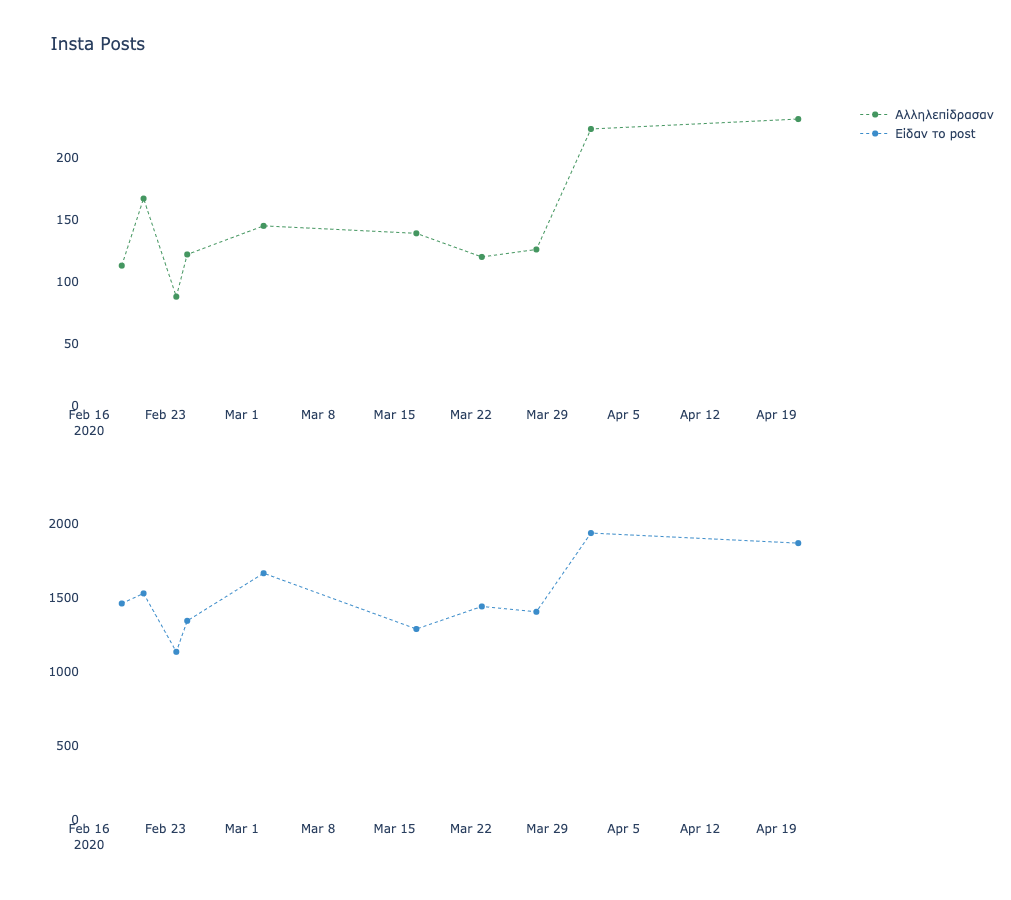

In [48]:
fig = make_subplots(2,1)

_=fig.add_trace(go.Scatter(x=posts.timestamp, y=posts.engagement,text = posts['caption split'],marker_color = colors['green_dark'],
                          hovertemplate = '%{x} <br>Αλληλεπίδρασαν: %{y:.0}<br><br>%{text}',
                           name='Αλληλεπίδρασαν', mode='lines+markers',line = linestyle),
                row=1,col=1)

_=fig.add_trace(go.Scatter(x=posts.timestamp, y=posts.reach,text = posts['caption split'],marker_color = colors['blue'],
                          hovertemplate = '%{x} <br>Είδαν το post: %{y:.0}<br><br>%{text}',
                          name='Είδαν το post', mode='lines+markers',line = linestyle),
                row=2,col=1)

_=fig.update_yaxes(rangemode='tozero')
fig.update_layout(height=900, width=1200, 
                  title_text="Insta Posts",
                  paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)')



# fig.write_html("outputs/posts.html")

# Followers

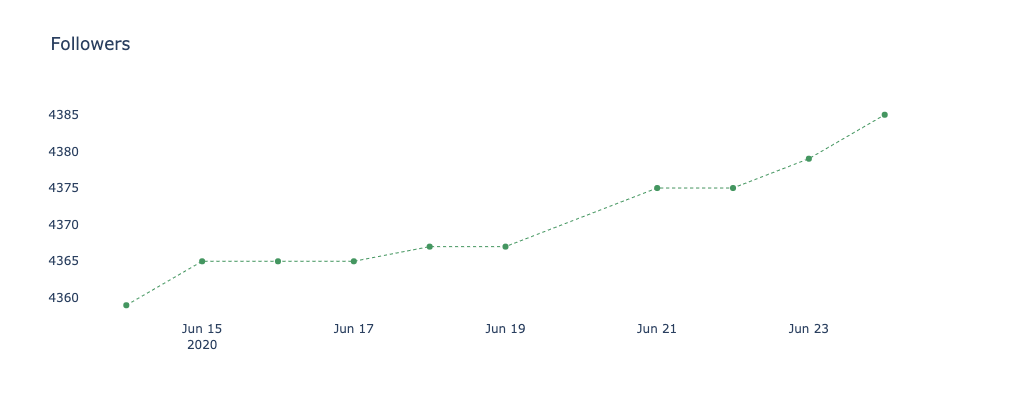

In [72]:
fig = make_subplots(1,1)

_=fig.add_trace(go.Scatter(x=account.sort_index().index, y=account.sort_index(), marker_color = colors['green_dark'],
                          hovertemplate = '%{x} <br>Followers: %{y:.0}<br>',
                           name='Followers', mode='lines+markers',line = linestyle),
                row=1,col=1)

fig.update_layout(height=400, width=1200, 
                  title_text="Followers",
                  paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)')



# fig.write_html("outputs/followers.html")